In [1]:
# Dependencias
import os
import math
import tempfile
import tensorflow as tf 
import numpy as np 
import pandas as pd
import sklearn.metrics
import matplotlib.pyplot as plt 
import tensorflow.keras.backend as K
import tensorflow_datasets as tfds
from tensorflow.keras import datasets, utils, preprocessing
from tensorflow.keras import models, losses, optimizers
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import regularizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from numpy.random import seed
from tensorflow import random

In [2]:
# Comprobar versión de TensorFlow
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

#apaño para un error
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

 
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
#fin apaño

# Fijar semilla
seed(22)
random.set_seed(22)

2.3.0
Num GPUs Available:  0


In [3]:
# Obtener dataset
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)

In [4]:
# Normalizar datos de test y train (originalmente 255 valores)
x_test = x_test.astype('float32')
x_train = x_train.astype('float32')
x_test /= 255
x_train /= 255

img_rows, img_cols = 32, 32
num_dim = 3
num_classes = 10

# Pasar de matriz a vectores
#x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, num_dim)
#x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, num_dim)

print(x_test.shape)
print(x_train.shape)

(10000, 32, 32, 3)
(50000, 32, 32, 3)


In [5]:
# Codificación One-hot para las clases
y_test_oh = to_categorical(y_test, num_classes)
y_train_oh = to_categorical(y_train, num_classes)

print(y_test_oh.shape)
print(y_train_oh.shape)

(10000, 10)
(50000, 10)


In [6]:
# Reimplementación en Keras de VGG16
# Basada en https://towardsdatascience.com/step-by-step-vgg16-implementation-in-keras-for-beginners-a833c686ae6c

vgg16 = Sequential()

weight_decay = 0.0005

vgg16.add(Conv2D(64, (3, 3), padding='same',
                         input_shape=(img_rows, img_cols, num_dim),kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.3))

vgg16.add(Conv2D(64, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())

vgg16.add(MaxPooling2D(pool_size=(2, 2)))

vgg16.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(128, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())

vgg16.add(MaxPooling2D(pool_size=(2, 2)))

vgg16.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(256, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())

vgg16.add(MaxPooling2D(pool_size=(2, 2)))

vgg16.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())

vgg16.add(MaxPooling2D(pool_size=(2, 2)))

vgg16.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())
vgg16.add(Dropout(0.4))

vgg16.add(Conv2D(512, (3, 3), padding='same',kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())

vgg16.add(MaxPooling2D(pool_size=(2, 2)))
vgg16.add(Dropout(0.5))

vgg16.add(Flatten())
vgg16.add(Dense(512,kernel_regularizer=regularizers.l2(weight_decay)))
vgg16.add(Activation('relu'))
vgg16.add(BatchNormalization())

vgg16.add(Dropout(0.5))
vgg16.add(Dense(num_classes))
vgg16.add(Activation('softmax'))

# Imprimimos resumen de la red
vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [7]:
# Definición de hiperparámetros
learning_rate = 0.1  # learning rate
batch_size = 128   # Tamaño del batch
epochs = 20  # Número de epochs
adam = optimizers.SGD(learning_rate=learning_rate)

# Compilamos la red neuronal
vgg16.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
vgg16.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
activation (Activation)      (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 64)        256       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 64)        36928     
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 64)        2

In [8]:
Datagen = preprocessing.image.ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False)  # randomly flip images
# (std, mean, and principal components if ZCA whitening is applied).

In [9]:
# Entrenamos el modelo
history = vgg16.fit_generator(Datagen.flow(x_train, y_train_oh,
                                batch_size=batch_size), epochs=epochs,
                                validation_data=(x_test, y_test_oh))

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/20
391/391 [==============================] - 601s 2s/step - loss: 4.7505 - accuracy: 0.2401 - val_loss: 4.8860 - val_accuracy: 0.2362
Epoch 2/20
391/391 [==============================] - 597s 2s/step - loss: 4.1849 - accuracy: 0.3445 - val_loss: 5.0517 - val_accuracy: 0.2944
Epoch 3/20
391/391 [==============================] - 598s 2s/step - loss: 3.9413 - accuracy: 0.3992 - val_loss: 5.8845 - val_accuracy: 0.3299
Epoch 4/20
391/391 [==============================] - 599s 2s/step - loss: 3.6157 - accuracy: 0.4474 - val_loss: 3.4978 - val_accuracy: 0.4678
Epoch 5/20
391/391 [==============================] - 598s 2s/step - loss: 3.3258 - accuracy: 0.5031 - val_loss: 3.3842 - val_accuracy: 0.5239
Epoch 6/20
391/391 [==============================] - 597s 2s/step - loss: 3.1622 - accuracy: 0.5216 - val_loss: 3.4014 - val_accuracy: 0.4596
Epoch 7/20
391/391 [==============================] - 598s 2s/step

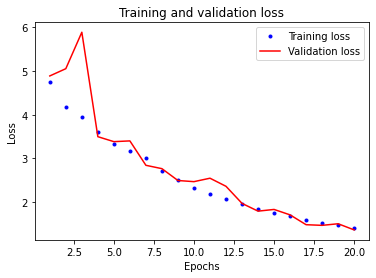

In [10]:
# Pintar gráfica de Loss 
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b.', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Probar inferencia
# vgg16.load_weights('cifar10vgg.h5')
vgg16.evaluate(x_test, y_test_oh, batch_size=64, verbose=1)

157/157 [==============================] - 15s 95ms/step - loss: 1.3671 - accuracy: 0.8075


[1.36705482006073, 0.8075000047683716]

In [13]:
# Guardar a disco modelo de Keras en formato h5 y h5py
vgg16.save('vgg16Keras.h5')